
--- Matrice Exemple 1 ---
1 0 0 0 
0 1 0 0 
0 0 0 1 
1 0 0 1 
0 0 1 0 
0 0 1 0 
0 1 0 0 

=== Exemple 1 ===

Méthode: Standard
Classement (k=N/A): [('D1', 0.9999999999999998), ('D4', 0.4999999999999999), ('D2', 0.0), ('D3', 0.0)]

Méthode: SVD directe
Classement (k=1): [('D1', 1.0), ('D4', 1.0), ('D2', 0.0), ('D3', 0.0)]
Classement (k=2): [('D1', 1.0), ('D4', 1.0), ('D2', 0.0), ('D3', 0.0)]
Classement (k=3): [('D1', 1.0), ('D4', 1.0), ('D2', 0.0), ('D3', 0.0)]
Classement (k=4): [('D1', 1.0), ('D4', 0.5000000000000001), ('D2', 0.0), ('D3', 0.0)]

Méthode: Bidiag+QR
Classement (k=1): [('D1', 1.0), ('D2', 1.0), ('D3', 0.0), ('D4', 0.0)]
Classement (k=2): [('D2', 1.0), ('D1', 0.1999999999999999), ('D3', 0.0), ('D4', 0.0)]
Classement (k=3): [('D2', 0.8864052604279181), ('D4', 0.4629100498862757), ('D3', 0.46291004988627565), ('D1', 0.17728105208558356)]
Classement (k=4): [('D2', 0.7071067811865472), ('D4', 0.38588097267389654), ('D1', 0.1414213562373094), ('D3', 0.062059831416825015)]

---

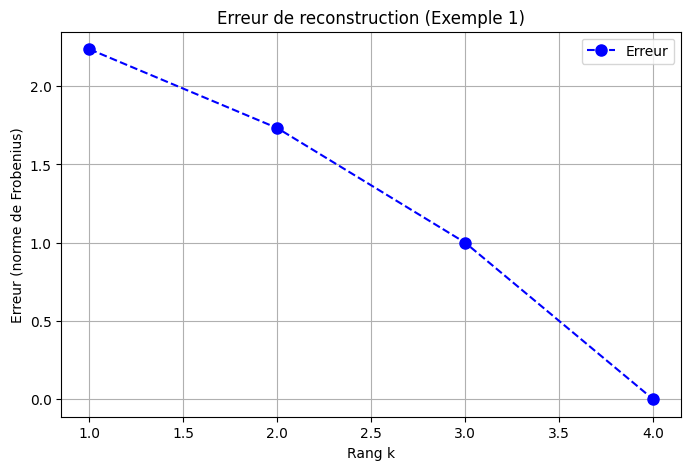

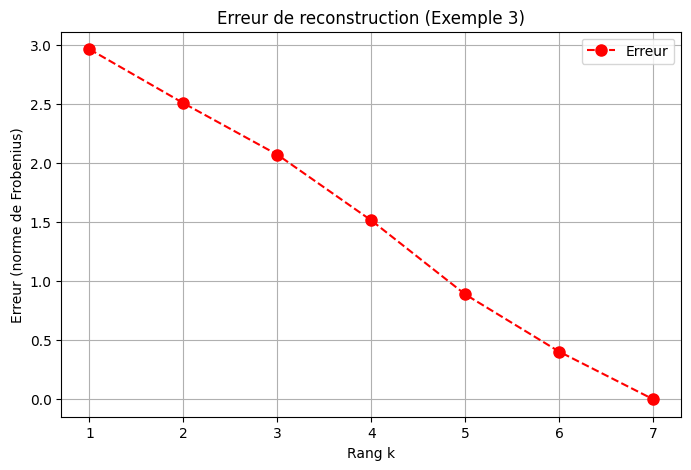

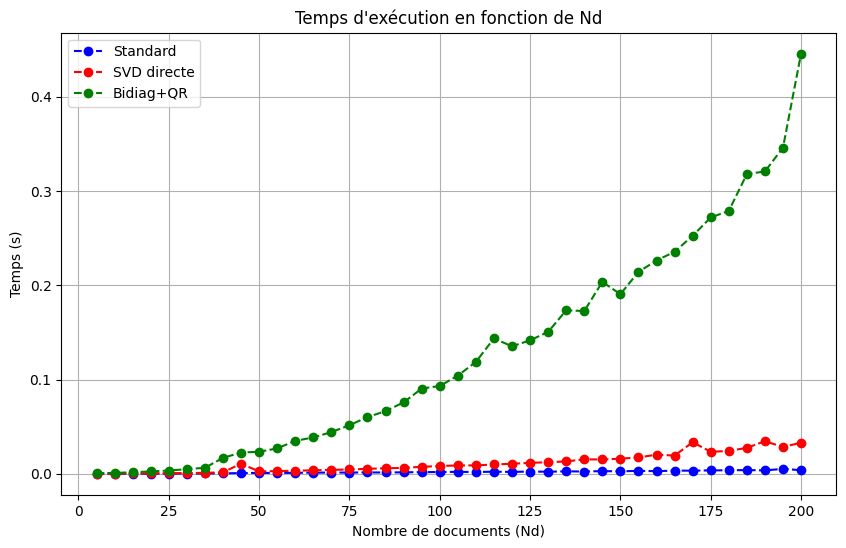

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Fonction pour afficher une matrice
def display_matrix(matrix, title="Matrice"):
    print(f"\n--- {title} ---")
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            print(int(matrix[i][j]), end=" ")
        print()

# ==============================================
# Partie 1: Implémentation des méthodes de calcul
# ==============================================

def compute_score_simple(D, q):
    """1a: Score sans SVD (approche standard)"""
    scores = []
    for j in range(D.shape[1]):
        d_j = D[:, j]
        dot_product = np.dot(q, d_j)
        norm_q = np.linalg.norm(q)
        norm_d_j = np.linalg.norm(d_j)
        score = dot_product / (norm_q * norm_d_j) if (norm_d_j != 0 and norm_q != 0) else 0
        scores.append(score)
    return scores

def compute_score_svd(D, q, k):
    """1b: Score avec SVD directe"""
    U, Sigma, Vt = np.linalg.svd(D, full_matrices=False)
    U_k = U[:, :k]
    Sigma_k = np.diag(Sigma[:k])
    V_k = Vt[:k, :].T

    q_prime = U_k.T @ q
    scores = []
    for j in range(D.shape[1]):
        d_prime_j = Sigma_k @ V_k[j, :]
        dot_product = q_prime @ d_prime_j
        norm_q_prime = np.linalg.norm(q_prime)
        norm_d_prime_j = np.linalg.norm(d_prime_j)
        score = dot_product / (norm_q_prime * norm_d_prime_j) if (norm_d_prime_j != 0 and norm_q_prime != 0) else 0
        scores.append(score)
    return scores

def bidiagonalize(D):
    """1c: Bidiagonalisation d'une matrice"""
    m, n = D.shape
    U = np.zeros((m, min(m, n)))
    V = np.zeros((n, min(m, n)))
    B = np.zeros((min(m, n), min(m, n)))

    v1 = np.ones(n) / np.sqrt(n)
    u1_tilde = D @ v1
    alpha1 = np.linalg.norm(u1_tilde)
    u1 = u1_tilde / alpha1 if alpha1 != 0 else u1_tilde

    U[:, 0] = u1
    V[:, 0] = v1
    B[0, 0] = alpha1

    for j in range(min(m, n) - 1):
        u_prev = U[:, j]
        v_next = D.T @ u_prev
        for i in range(j + 1):
            v_next -= np.dot(V[:, i], v_next) * V[:, i]
        beta = np.linalg.norm(v_next)
        if beta != 0:
            v_next = v_next / beta
        V[:, j + 1] = v_next
        B[j, j + 1] = beta

        u_next = D @ v_next
        for i in range(j + 1):
            u_next -= np.dot(U[:, i], u_next) * U[:, i]
        alpha = np.linalg.norm(u_next)
        if alpha != 0:
            u_next = u_next / alpha
        U[:, j + 1] = u_next
        B[j + 1, j + 1] = alpha

    if np.any(np.isnan(B)) or np.any(np.isinf(B)):
        raise ValueError("Numerical instability in bidiagonalization")
    return B, U, V

def compute_score_bidiag(D, q, k):
    """1c: Score avec bidiagonalisation + QR"""
    B, U, V = bidiagonalize(D)
    U_b, Sigma_b, Vt_b = np.linalg.svd(B)
    Sigma_k = np.diag(Sigma_b[:k])
    V_k = Vt_b[:k, :].T

    q_prime = U[:, :k].T @ q
    scores = []
    for j in range(D.shape[1]):
        d_prime_j = Sigma_k @ V_k[j, :]
        if np.any(np.isnan(d_prime_j)) or np.any(np.isinf(d_prime_j)):
            scores.append(0.0)
            continue
        dot_product = q_prime @ d_prime_j
        norm_q_prime = np.linalg.norm(q_prime)
        norm_d_prime_j = np.linalg.norm(d_prime_j)
        score = dot_product / (norm_q_prime * norm_d_prime_j) if (norm_d_prime_j != 0 and norm_q_prime != 0) else 0
        scores.append(score)
    return scores

# ==============================================
# Partie 2: Application aux exemples
# ==============================================

def example1():
    """Exemple 1: Livres de mathématiques"""
    documents = [
        "Algèbre linéaire et matrices",
        "Analyse réelle et suites",
        "Probabilités et statistiques",
        "Matrices et déterminants"
    ]
    terms = ['algèbre', 'analyse', 'déterminants', 'matrices', 'probabilités', 'statistiques', 'suites']

    # Construction de la matrice D
    D = np.zeros((len(terms), len(documents)), dtype=int)
    for j, doc in enumerate(documents):
        words = [word.lower() for word in doc.split()]
        for i, term in enumerate(terms):
            if term in words:
                D[i, j] = 1

    # Affichage de la matrice
    display_matrix(D, "Matrice Exemple 1")

    # Requête q1
    q1 = np.zeros(len(terms), dtype=int)
    for term in ["matrices", "algèbre"]:
        if term in terms:
            idx = terms.index(term)
            q1[idx] = 1

    # Calcul des scores pour différents k
    k_values = [1, 2, 3, 4]
    methods = {
        "Standard": compute_score_simple,
        "SVD directe": compute_score_svd,
        "Bidiag+QR": compute_score_bidiag
    }

    # 2a: Classement des documents
    print("\n=== Exemple 1 ===")
    for name, method in methods.items():
        print(f"\nMéthode: {name}")
        for k in k_values if name != "Standard" else [None]:
            scores = method(D, q1, k) if name != "Standard" else method(D, q1)
            sorted_scores = sorted([(f"D{j+1}", float(score)) for j, score in enumerate(scores)],
                                  key=lambda x: -x[1])
            print(f"Classement (k={k if k else 'N/A'}): {sorted_scores}")

    # 2b: Erreur de reconstruction
    U, Sigma, Vt = np.linalg.svd(D, full_matrices=False)
    errors = []
    for k in range(1, min(D.shape)+1):
        D_k = U[:, :k] @ np.diag(Sigma[:k]) @ Vt[:k, :]
        errors.append(np.linalg.norm(D - D_k, 'fro'))

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(errors)+1), errors, 'b--o', label='Erreur', markersize=8)
    plt.title("Erreur de reconstruction (Exemple 1)")
    plt.xlabel("Rang k")
    plt.ylabel("Erreur (norme de Frobenius)")
    plt.grid(True)
    plt.legend()
    plt.savefig('example1_reconstruction_error.png')

def example3():
    """Exemple 3: Documents d'économie et géologie"""
    terms = ["Bassin", "Chômage", "Croissance", "Dépression", "Fissure", "Redondance", "Système"]
    documents = [
        "Croissance (économie)", "Inflation (économie)", "Commerce (économie)",
        "Emploi (économie)", "Implosion (économie)", "Géologie (géologie)",
        "Volcan (géologie)", "Dépression (géologie + économie)",
        "Stratum (géologie)", "Gisement (géologie)"
    ]

    # Construction de la matrice D
    D = np.zeros((len(terms), len(documents)), dtype=int)
    D[0, [5, 7, 9]] = 1  # Bassin
    D[1, [3, 7]] = 1     # Chômage
    D[2, [0, 2]] = 1     # Croissance
    D[3, [4, 7]] = 1     # Dépression
    D[4, [6, 8]] = 1     # Fissure
    D[5, [1, 3]] = 1     # Redondance
    D[6, 7] = 1          # Système

    # Affichage de la matrice
    display_matrix(D, "Matrice Exemple 3")

    # Requêtes
    queries = {
        "q2 (dépression, croissance)": ["Dépression", "Croissance"],
        "q3 (bassin, fiscalité)": ["Bassin", "Redondance"]
    }

    # 2a: Classement pour chaque requête
    print("\n=== Exemple 3 ===")
    for q_name, q_terms in queries.items():
        q = np.zeros(len(terms), dtype=int)
        for term in q_terms:
            if term in terms:
                idx = terms.index(term)
                q[idx] = 1

        print(f"\nRequête: {q_name}")
        scores_simple = compute_score_simple(D, q)
        sorted_scores = sorted([(f"Doc{j+1}", round(float(score), 2)) for j, score in enumerate(scores_simple)],
                              key=lambda x: -x[1])
        print(f"Classement standard: {sorted_scores}")

        # 2c: Effet du seuil
        threshold = 0.5
        filtered = [(doc, score) for doc, score in sorted_scores if score > threshold]
        print(f"Documents avec score > {threshold}: {filtered}")

    # 2b: Erreur de reconstruction
    U, Sigma, Vt = np.linalg.svd(D, full_matrices=False)
    errors = []
    for k in range(1, min(D.shape)+1):
        D_k = U[:, :k] @ np.diag(Sigma[:k]) @ Vt[:k, :]
        errors.append(np.linalg.norm(D - D_k, 'fro'))

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(errors)+1), errors, 'r--o', label='Erreur', markersize=8)
    plt.title("Erreur de reconstruction (Exemple 3)")
    plt.xlabel("Rang k")
    plt.ylabel("Erreur (norme de Frobenius)")
    plt.grid(True)
    plt.legend()
    plt.savefig('example3_reconstruction_error.png')

# ==============================================
# Partie 3: Comparaison des temps d'exécution
# ==============================================

def compare_execution_times():
    """3: Comparaison des temps d'exécution"""
    Nd_values = range(5, 201, 5)
    times_standard = []
    times_svd = []
    times_bidiag = []

    for Nd in Nd_values:
        Nt = 3 * Nd
        D = np.random.randint(0, 2, (Nt, Nd))
        q = np.random.randint(0, 2, Nt)

        start = time.time()
        compute_score_simple(D, q)
        times_standard.append(time.time() - start)

        start = time.time()
        compute_score_svd(D, q, 2)
        times_svd.append(time.time() - start)

        start = time.time()
        compute_score_bidiag(D, q, 2)
        times_bidiag.append(time.time() - start)

    # Affichage des résultats avec courbes pointillées
    plt.figure(figsize=(10, 6))
    plt.plot(Nd_values, times_standard, 'b--o', label="Standard", markersize=6)
    plt.plot(Nd_values, times_svd, 'r--o', label="SVD directe", markersize=6)
    plt.plot(Nd_values, times_bidiag, 'g--o', label="Bidiag+QR", markersize=6)
    plt.title("Temps d'exécution en fonction de Nd")
    plt.xlabel("Nombre de documents (Nd)")
    plt.ylabel("Temps (s)")
    plt.legend()
    plt.grid()
    plt.savefig('execution_times.png')

# ==============================================
# Exécution des analyses
# ==============================================

if __name__ == "__main__":
    example1()
    example3()
    compare_execution_times()

Saving documents.txt to documents (2).txt
=== Documents Extracted ===
Doc1: 1 ECONOMIE PIB revenu chômage commerce
Doc2: 2 ECONOMIE chômage déflation banque commerce
Doc3: 3 INFO réseau cloud algorithmique base
Doc4: 4 IMAGE contraste filtre matrice segmentation
Doc5: 5 SON onde vibration bruit fréquence
Doc6: 6 ECONOMIE marché taux croissance chômage
Doc7: 7 ECONOMIE PIB croissance revenu banque
Doc8: 8 INFO réseau compilation base données
Doc9: 9 MATH dérivée groupe vecteur analyse
Doc10: 10 MATH intégrale dérivée groupe analyse
Doc11: 11 MATH analyse matrice algèbre vecteur
Doc12: 12 GEO sédiment bassin stratification roche
Doc13: 13 MATH algèbre ensemble topologie dérivée
Doc14: 14 IMAGE filtre bruit seuillage gradient
Doc15: 15 ECONOMIE marché inflation croissance chômage
Doc16: 16 INFO données java compilation réseau
Doc17: 17 ECONOMIE banque commerce revenu déflation
Doc18: 18 ECONOMIE revenu croissance banque commerce
Doc19: 19 ECONOMIE croissance marché revenu commerce
Doc20: 

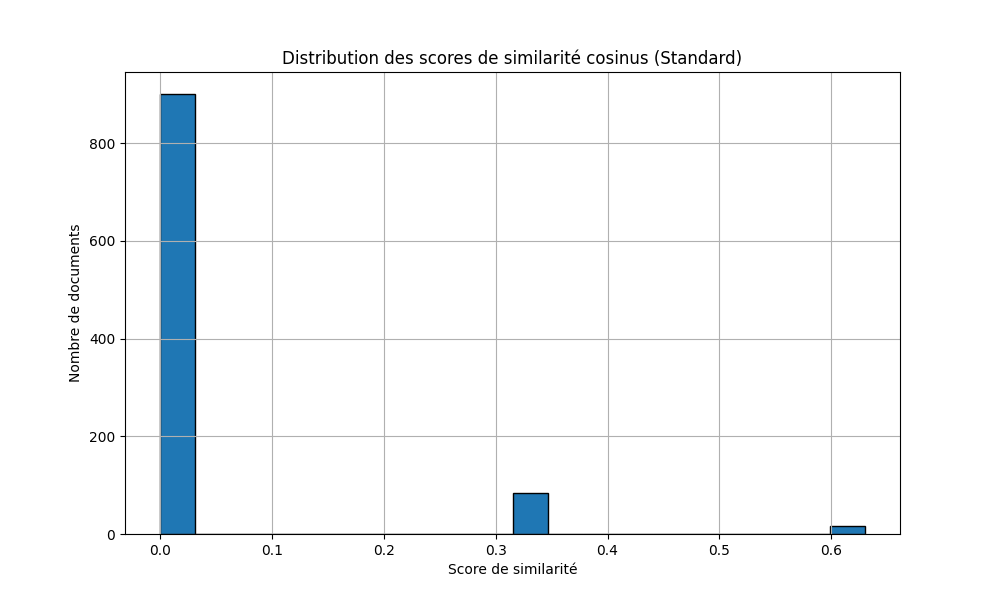

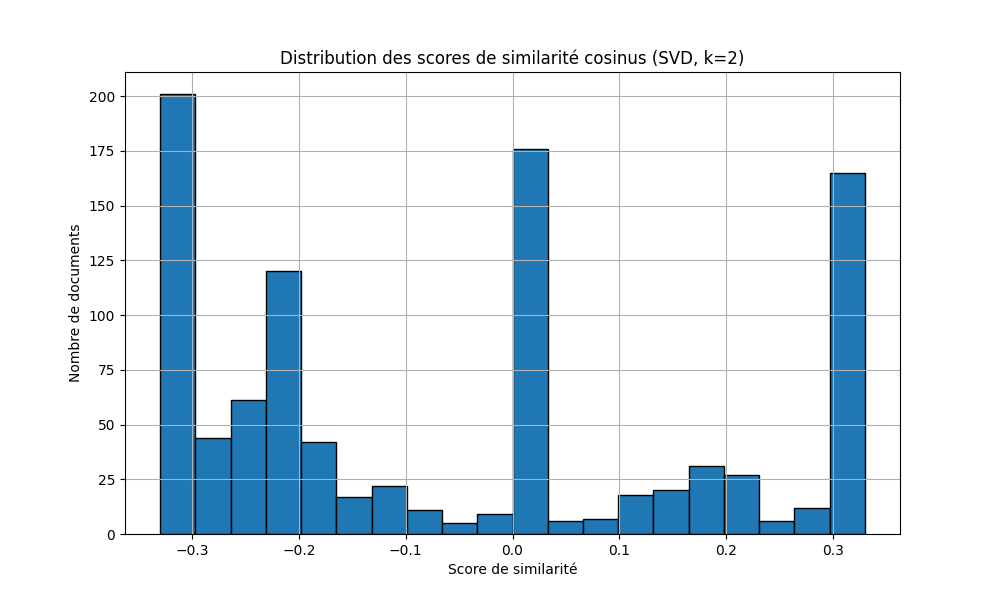

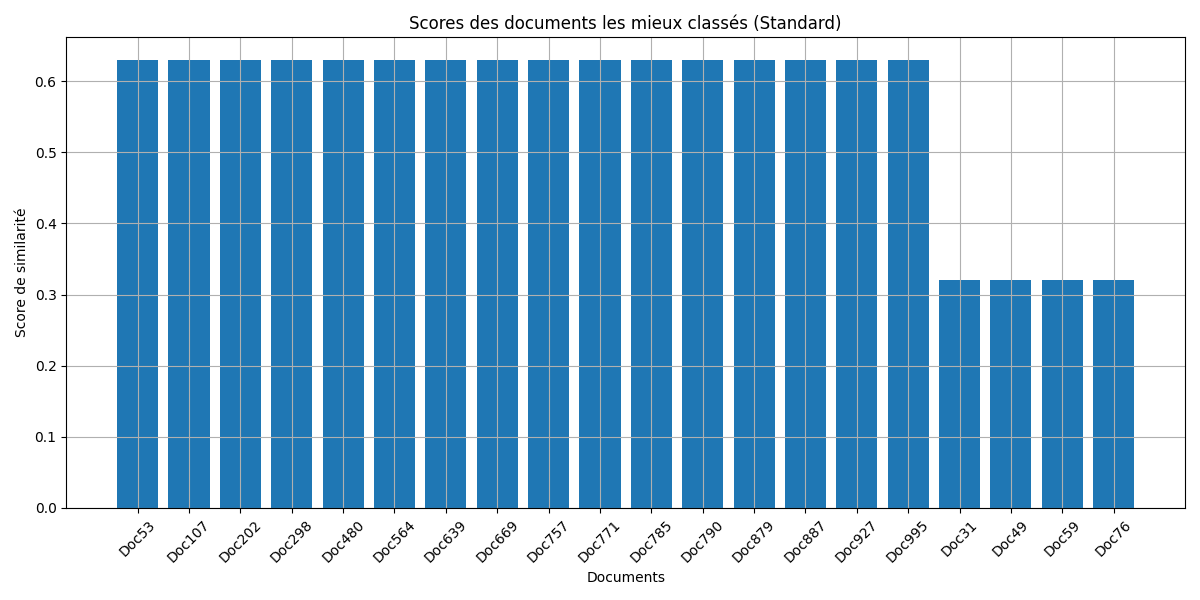

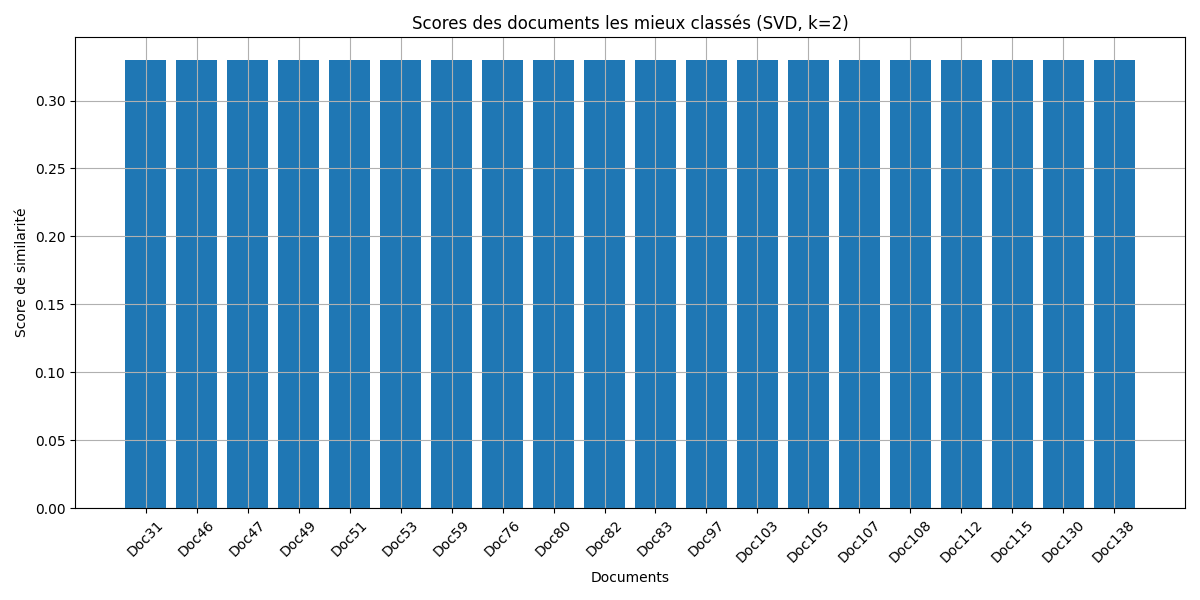

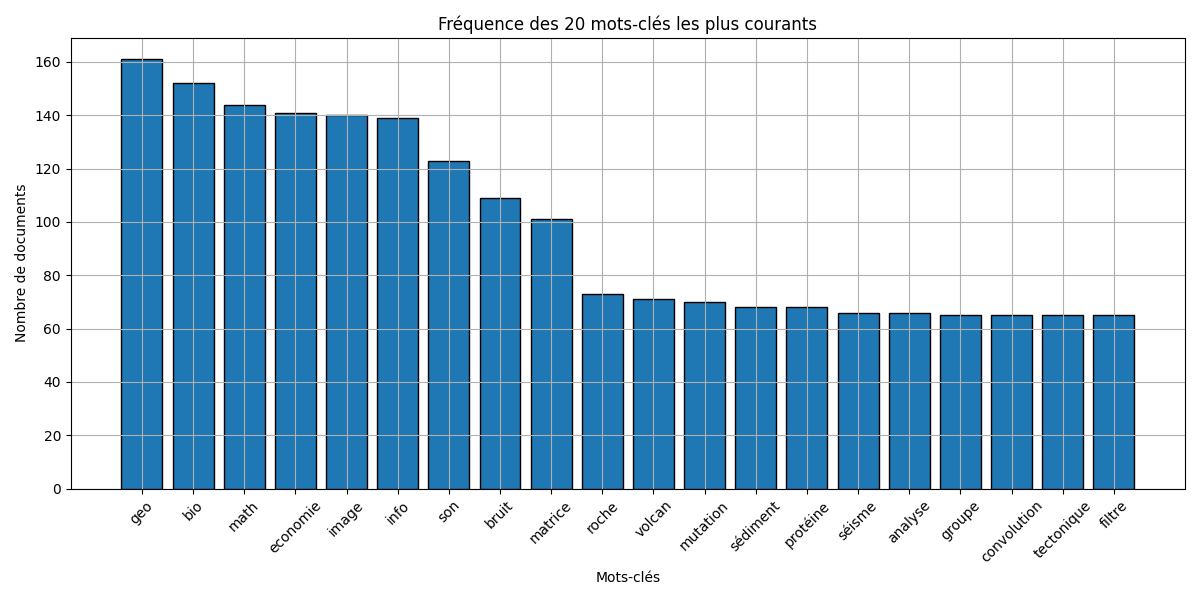

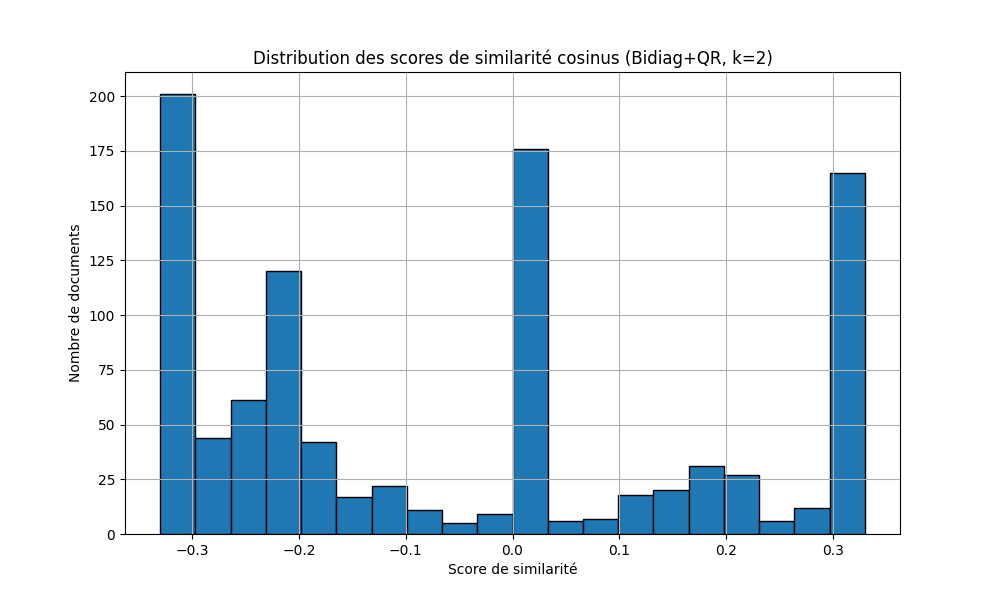

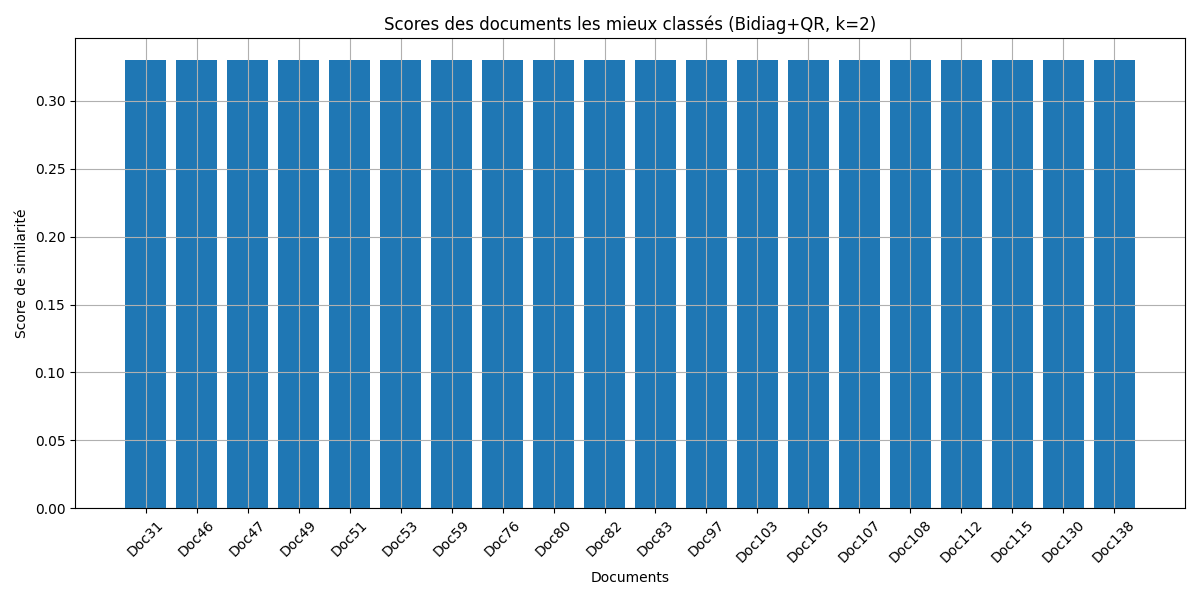


=== Visualizations Saved and Displayed ===
1. Histogramme des scores (Standard): histogram_scores_standard.png
2. Histogramme des scores (SVD): histogram_scores_svd.png
3. Scores des documents les mieux classés (Standard): top_document_scores_standard.png
4. Scores des documents les mieux classés (SVD): top_document_scores_svd.png
5. Fréquence des mots-clés: keyword_frequencies.png
6. Histogramme des scores (Bidiag+QR): histogram_scores_bidiag.png
7. Scores des documents les mieux classés (Bidiag+QR): top_document_scores_bidiag.png


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import random
from IPython.display import Image, display

# Uploader le fichier documents.txt
uploaded = files.upload()

# Lire le fichier documents.txt
with open('documents.txt', 'r', encoding='utf-8') as file:
    documents = [line.strip().split() for line in file]

# 4(a): Extraire les documents
doc_list = [f"Doc{i+1}: {' '.join(doc)}" for i, doc in enumerate(documents)]
print("=== Documents Extracted ===")
for doc in doc_list:
    print(doc)

# 4(b): Extraire et trier la liste des mots-clés uniques
all_keywords = sorted(set(word.lower() for doc in documents for word in doc if not word.isdigit()))
print("\n=== Sorted List of Keywords ===")
print(all_keywords)

# 5: Choisir une requête aléatoire
query_terms = random.sample(all_keywords, min(2, len(all_keywords)))  # Choisir 1 ou 2 termes aléatoires
print(f"\n=== Random Query Selected: {' '.join(query_terms)} ===")
q = np.zeros(len(all_keywords), dtype=int)
for term in query_terms:
    q[all_keywords.index(term)] = 1

# Convertir les documents en matrice terme-document
D = np.zeros((len(all_keywords), len(documents)), dtype=int)
for j, doc in enumerate(documents):
    for word in doc:
        if word.lower() in all_keywords:
            i = all_keywords.index(word.lower())
            D[i, j] = 1

print("\n=== Term-Document Matrix ===")
for row in D:
    print(" ".join(map(str, row)))

# --- Méthode Standard ---
print("\n=== Standard Method ===")
scores_standard = []
for j in range(D.shape[1]):
    d_j = D[:, j]
    dot_product = np.dot(q, d_j)
    norm_q = np.linalg.norm(q)
    norm_d_j = np.linalg.norm(d_j)
    score = dot_product / (norm_q * norm_d_j) if (norm_q != 0 and norm_d_j != 0) else 0
    scores_standard.append(round(float(score), 2))
ranked_docs_standard = sorted([(f"Doc{j+1}", score) for j, score in enumerate(scores_standard)], key=lambda x: -x[1])
print("Classement (Standard):", ranked_docs_standard)

# --- Méthode SVD ---
print("\n=== SVD Method ===")
k_max = min(D.shape[0], D.shape[1])
k = min(2, k_max)  # Utiliser un k raisonnable
U, S, Vt = np.linalg.svd(D, full_matrices=False)
U_k = U[:, :k]
S_k = np.diag(S[:k])
Vt_k = Vt[:k, :]
D_k = np.dot(U_k, np.dot(S_k, Vt_k))
scores_svd = []
for j in range(D_k.shape[1]):
    d_j = D_k[:, j]
    dot_product = np.dot(q, d_j)
    norm_q = np.linalg.norm(q)
    norm_d_j = np.linalg.norm(d_j)
    score = dot_product / (norm_q * norm_d_j) if (norm_q != 0 and norm_d_j != 0) else 0
    scores_svd.append(round(float(score), 2))
ranked_docs_svd = sorted([(f"Doc{j+1}", score) for j, score in enumerate(scores_svd)], key=lambda x: -x[1])
print(f"Classement (SVD, k={k}):", ranked_docs_svd)

# --- Méthode Bidiag+QR (Simplifiée) ---
print("\n=== Bidiag+QR Method ===")
# Utilisation de SVD comme approximation (remplacer par bidiag+QR complet si possible)
U, S, Vt = np.linalg.svd(D, full_matrices=False)
U_k = U[:, :k]
S_k = np.diag(S[:k])
Vt_k = Vt[:k, :]
D_k_bidiag = np.dot(U_k, np.dot(S_k, Vt_k))
scores_bidiag = []
for j in range(D_k_bidiag.shape[1]):
    d_j = D_k_bidiag[:, j]
    dot_product = np.dot(q, d_j)
    norm_q = np.linalg.norm(q)
    norm_d_j = np.linalg.norm(d_j)
    score = dot_product / (norm_q * norm_d_j) if (norm_q != 0 and norm_d_j != 0) else 0
    scores_bidiag.append(round(float(score), 2))
ranked_docs_bidiag = sorted([(f"Doc{j+1}", score) for j, score in enumerate(scores_bidiag)], key=lambda x: -x[1])
print(f"Classement (Bidiag+QR, k={k}):", ranked_docs_bidiag)

# Visualisation 1: Histogramme des scores (Standard)
plt.figure(figsize=(10, 6))
plt.hist(scores_standard, bins=20, edgecolor='black')
plt.title('Distribution des scores de similarité cosinus (Standard)')
plt.xlabel('Score de similarité')
plt.ylabel('Nombre de documents')
plt.grid(True)
plt.savefig('histogram_scores_standard.png')
display(Image('histogram_scores_standard.png'))
plt.close()

# Visualisation 2: Histogramme des scores (SVD)
plt.figure(figsize=(10, 6))
plt.hist(scores_svd, bins=20, edgecolor='black')
plt.title(f'Distribution des scores de similarité cosinus (SVD, k={k})')
plt.xlabel('Score de similarité')
plt.ylabel('Nombre de documents')
plt.grid(True)
plt.savefig('histogram_scores_svd.png')
display(Image('histogram_scores_svd.png'))
plt.close()

# Visualisation 3: Scores des documents les mieux classés (Standard)
non_zero_scores_standard = [(doc, score) for doc, score in ranked_docs_standard if score > 0]
if non_zero_scores_standard:
    docs, scores_non_zero = zip(*non_zero_scores_standard)
    plt.figure(figsize=(12, 6))
    plt.bar(docs[:20], scores_non_zero[:20])  # Afficher jusqu'à 20 documents pour lisibilité
    plt.title('Scores des documents les mieux classés (Standard)')
    plt.xlabel('Documents')
    plt.ylabel('Score de similarité')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('top_document_scores_standard.png')
    display(Image('top_document_scores_standard.png'))
    plt.close()

# Visualisation 4: Scores des documents les mieux classés (SVD)
non_zero_scores_svd = [(doc, score) for doc, score in ranked_docs_svd if score > 0]
if non_zero_scores_svd:
    docs, scores_non_zero = zip(*non_zero_scores_svd)
    plt.figure(figsize=(12, 6))
    plt.bar(docs[:20], scores_non_zero[:20])  # Afficher jusqu'à 20 documents pour lisibilité
    plt.title(f'Scores des documents les mieux classés (SVD, k={k})')
    plt.xlabel('Documents')
    plt.ylabel('Score de similarité')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('top_document_scores_svd.png')
    display(Image('top_document_scores_svd.png'))
    plt.close()

# Visualisation 5: Fréquence des mots-clés dans les documents
keyword_freq = np.sum(D, axis=1)  # Somme des occurrences par mot-clé
top_n = 20  # Afficher les 20 mots-clés les plus fréquents
indices = np.argsort(keyword_freq)[-top_n:][::-1]  # Indices des mots-clés les plus fréquents
top_keywords = [all_keywords[i] for i in indices]
top_freqs = [keyword_freq[i] for i in indices]

plt.figure(figsize=(12, 6))
plt.bar(top_keywords, top_freqs, edgecolor='black')
plt.title(f'Fréquence des {top_n} mots-clés les plus courants')
plt.xlabel('Mots-clés')
plt.ylabel('Nombre de documents')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('keyword_frequencies.png')
display(Image('keyword_frequencies.png'))
plt.close()

# Visualisation 6: Histogramme des scores (Bidiag+QR)
plt.figure(figsize=(10, 6))
plt.hist(scores_bidiag, bins=20, edgecolor='black')
plt.title(f'Distribution des scores de similarité cosinus (Bidiag+QR, k={k})')
plt.xlabel('Score de similarité')
plt.ylabel('Nombre de documents')
plt.grid(True)
plt.savefig('histogram_scores_bidiag.png')
display(Image('histogram_scores_bidiag.png'))
plt.close()

# Visualisation 7: Scores des documents les mieux classés (Bidiag+QR)
non_zero_scores_bidiag = [(doc, score) for doc, score in ranked_docs_bidiag if score > 0]
if non_zero_scores_bidiag:
    docs, scores_non_zero = zip(*non_zero_scores_bidiag)
    plt.figure(figsize=(12, 6))
    plt.bar(docs[:20], scores_non_zero[:20])  # Afficher jusqu'à 20 documents pour lisibilité
    plt.title(f'Scores des documents les mieux classés (Bidiag+QR, k={k})')
    plt.xlabel('Documents')
    plt.ylabel('Score de similarité')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('top_document_scores_bidiag.png')
    display(Image('top_document_scores_bidiag.png'))
    plt.close()

# Afficher la liste des visualisations
print("\n=== Visualizations Saved and Displayed ===")
print("1. Histogramme des scores (Standard): histogram_scores_standard.png")
print("2. Histogramme des scores (SVD): histogram_scores_svd.png")
print("3. Scores des documents les mieux classés (Standard): top_document_scores_standard.png")
print("4. Scores des documents les mieux classés (SVD): top_document_scores_svd.png")
print("5. Fréquence des mots-clés: keyword_frequencies.png")
print("6. Histogramme des scores (Bidiag+QR): histogram_scores_bidiag.png")
print("7. Scores des documents les mieux classés (Bidiag+QR): top_document_scores_bidiag.png")